<a href="https://colab.research.google.com/github/ThadeuFerreira/PyTorch-for-Deep-Learning-and-Computer-Vision-Course-All-Codes-/blob/master/PyTorch%20for%20Deep%20Learning%20and%20Computer%20Vision%20Course%20(All%20Codes)/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

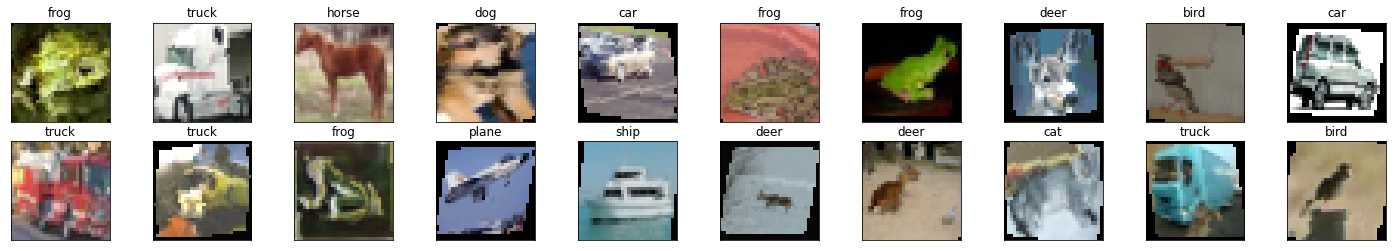

In [ ]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.6711, acc 38.4680 
validation loss: 1.3772, validation acc 49.8800 
epoch : 2
training loss: 1.3759, acc 50.4240 
validation loss: 1.2545, validation acc 55.0400 
epoch : 3
training loss: 1.2446, acc 55.5360 
validation loss: 1.1076, validation acc 60.6400 
epoch : 4
training loss: 1.1566, acc 58.8040 
validation loss: 1.0334, validation acc 63.6800 
epoch : 5
training loss: 1.0880, acc 61.3260 
validation loss: 1.0114, validation acc 64.6400 
epoch : 6
training loss: 1.0447, acc 63.0640 
validation loss: 0.9533, validation acc 66.5600 
epoch : 7
training loss: 1.0016, acc 64.8460 
validation loss: 0.9171, validation acc 67.5600 
epoch : 8
training loss: 0.9726, acc 66.1400 
validation loss: 0.8982, validation acc 68.2800 
epoch : 9
training loss: 0.9427, acc 66.9060 
validation loss: 0.9055, validation acc 68.7000 
epoch : 10
training loss: 0.9169, acc 67.6040 
validation loss: 0.8467, validation acc 70.4700 
epoch : 11
training loss: 0.8955, acc 68.5820 
va

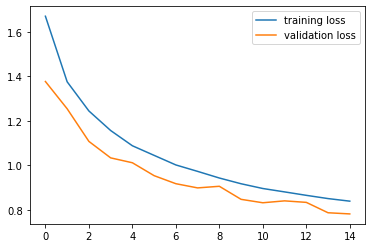

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
running_corrects_history

[tensor(38.4680, device='cuda:0'),
 tensor(50.4240, device='cuda:0'),
 tensor(55.5360, device='cuda:0'),
 tensor(58.8040, device='cuda:0'),
 tensor(61.3260, device='cuda:0'),
 tensor(63.0640, device='cuda:0'),
 tensor(64.8460, device='cuda:0'),
 tensor(66.1400, device='cuda:0'),
 tensor(66.9060, device='cuda:0'),
 tensor(67.6040, device='cuda:0'),
 tensor(68.5820, device='cuda:0'),
 tensor(69.0220, device='cuda:0'),
 tensor(69.8380, device='cuda:0'),
 tensor(69.9200, device='cuda:0'),
 tensor(70.8720, device='cuda:0')]

In [ ]:
val_running_corrects_history
out_running_corrects_history = np.array([np.array(tensor.cpu()).item() for tensor in running_corrects_history])
out_val_running_corrects_history = np.array([np.array(tensor.cpu()).item() for tensor in val_running_corrects_history])

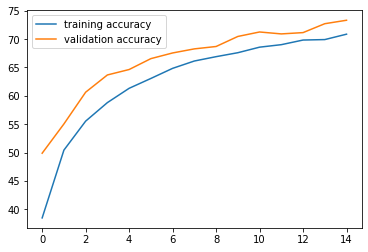

In [ ]:
plt.plot(out_running_corrects_history, label='training accuracy')
plt.plot(out_val_running_corrects_history, label='validation accuracy')
plt.legend()

In [ ]:
!pip3 install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 84.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pillow: filename=Pillow-4.0.0-cp38-cp38-linux_x86_64.whl size=1072810 sha256=ad71c3eaaf08f6aabb4861e868dc13cc088e4b771dca489ca072cc0d0270bc72
  Stored in directory: /root/.cache/pip/wheels/e3/2e/74/33a7284a964c402e6d2bb64b34b0b611e9f3a673c9bc2a00ab
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35430 sha256=85f0a830116770263a980d82097d506d3dc388c201e28d61865c00b13c8e31d9
  Stored in directory: /root/.cache/pip/wheels/0b/d8/16/1e2d32ad7455728b8af9efdb9d2a0c3d03cd8f2e4be0191b8c
Successfully built pillow olefile
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstallin

In [ ]:
import PIL.ImageOps

In [ ]:
import cv2
import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
url = 'https://th.bing.com/th/id/OIP.v_NmMMbr1QpbjwtxA7NGAAHaFG?pid=ImgDet&rs=1'
response = requests.get(url)
img_array = np.array(bytearray(response.content), dtype=np.uint8)
img = cv2.imdecode(img_array, -1)
img = Image.fromarray(img)


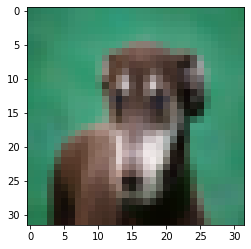

In [ ]:
img = transform(img) 
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog


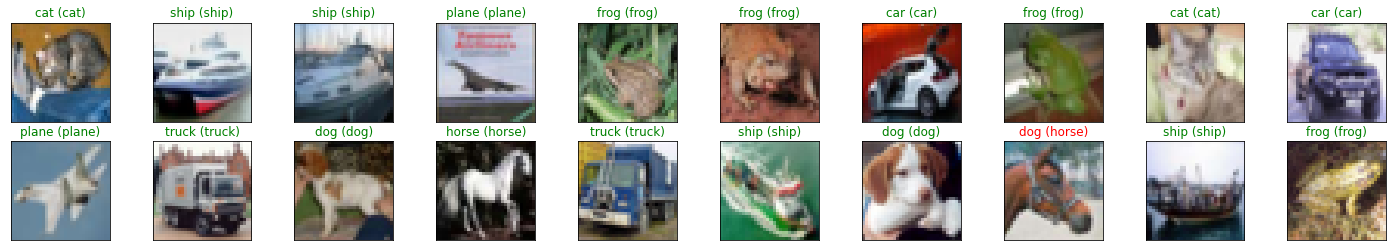

In [ ]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, 'model.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Assume you have a model named 'model' and a file named 'model.pth'
checkpoint = torch.load('model.pth')
model2 = LeNet().to(device)
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer2 = torch.optim.Adam(model.parameters(), lr = 0.001)
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
image = img.to(device).unsqueeze(0)
output = model2(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog
